In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import librosa
import torchaudio
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from tqdm.auto import tqdm
from IPython.display import Audio

In [2]:
file_path = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech'
data_path = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data'

train_data = pd.read_csv(os.path.join(file_path, 'train_data.csv'))
test_data = pd.read_csv(os.path.join(file_path, 'test_data.csv'))
df = pd.concat([train_data, test_data])

In [3]:
audio_files = {}

for index, row in df.iterrows():
    filename = row['filename']
    if type(filename) == str:
        filename = row['speaker_id'] + ' ' + filename.split('.')[0]
        if filename not in audio_files:
            audio_files[filename]={}
            
        
        if filename in audio_files:
            if row['is_audio'] is True and row['is_converted_audio'] == True:
                audio_files[filename]['audio_file'] = os.path.join(data_path, row['path_from_data_dir'])
            elif row['is_word_file'] is True:
                audio_files[filename]['word_file'] = os.path.join(data_path, row['path_from_data_dir'])
            elif row['is_phonetic_file'] is True:
                audio_files[filename]['phonetic_file'] = os.path.join(data_path, row['path_from_data_dir'])

In [4]:
audio_exSA_files = {}

for index, row in df.iterrows():
    filename = row['filename']
    if type(filename) == str:
        if filename.split('.')[0] in ['SA1','SA2']:
            continue
        filename = row['speaker_id'] + ' ' + filename.split('.')[0]
        
        if filename not in audio_exSA_files:
            audio_exSA_files[filename]={}
            
        
        if filename in audio_exSA_files:
            if row['is_audio'] is True and row['is_converted_audio'] == True:
                audio_exSA_files[filename]['audio_file'] = os.path.join(data_path, row['path_from_data_dir'])
            elif row['is_word_file'] is True:
                audio_exSA_files[filename]['word_file'] = os.path.join(data_path, row['path_from_data_dir'])
            elif row['is_phonetic_file'] is True:
                audio_exSA_files[filename]['phonetic_file'] = os.path.join(data_path, row['path_from_data_dir'])

In [5]:
print(len(audio_exSA_files))

5040


In [6]:
print(len(audio_files))
for key,value in audio_files.items():
    print ('key: ',key,'value: ',value)
    break

6300
key:  MMDM0 SI681 value:  {'audio_file': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR4/MMDM0/SI681.WAV.wav', 'phonetic_file': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR4/MMDM0/SI681.PHN', 'word_file': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR4/MMDM0/SI681.WRD'}


In [7]:
male_regions = [0] * 8
female_regions = [0] * 8

gender_regions_counts = [male_regions,female_regions]

for key,value in audio_files.items():
    gender = 0
    if key.startswith('F'):
        gender = 1
        
    file_list = value['audio_file'].split('/')
    for i in range(0,8):
        region = 'DR' + str(i+1)
        if region in file_list:
            gender_regions_counts[gender][i] += 1

print(gender_regions_counts)

[[310, 710, 790, 690, 620, 300, 740, 220], [180, 310, 230, 310, 360, 160, 260, 110]]


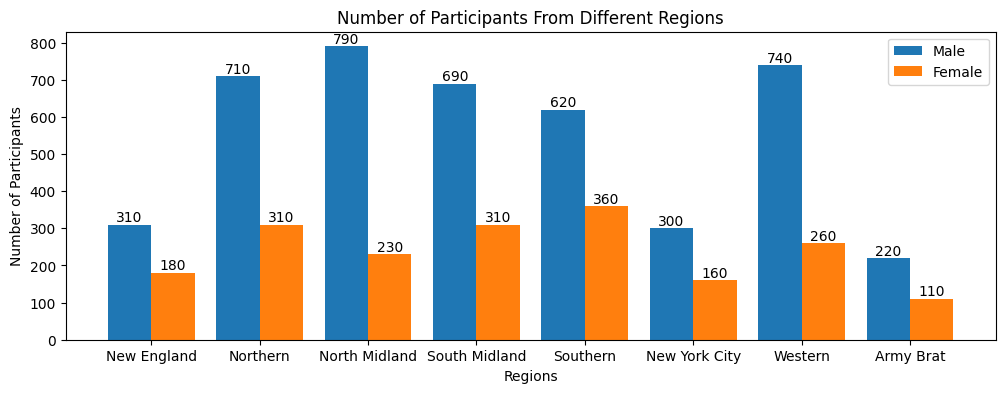

In [8]:
region_names = ['New England','Northern','North Midland','South Midland'
                ,'Southern','New York City','Western','Army Brat']
x = np.array(list(range(len(region_names))))
width = 0.4

plt.figure(figsize = (12,4))

rects1 = plt.bar(x - width/2, gender_regions_counts[0], width = width, label='Male')
rects2 = plt.bar(x + width/2, gender_regions_counts[1], width = width, label='Female')

for rect in rects1:
    height = rect.get_height()
    plt.text(rect.get_x() + width/2, height, str(height),size = 10, ha = 'center', va = 'bottom')

for rect in rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + width/2, height, str(height),size = 10, ha = 'center', va = 'bottom')


plt.xlabel('Regions')
plt.ylabel('Number of Participants')
plt.title('Number of Participants From Different Regions')
plt.xticks(ticks=x, labels=region_names, rotation = 0)
    
plt.legend()

plt.savefig('participants_and_regions.png')

plt.show()

In [9]:
female_files = {}
for index, row in df.iterrows():
    filename = row['filename']
    if type(filename) == str and row['speaker_id'].startswith('F'):
        if filename.split('.')[0] in ['SA1','SA2']:
            continue
        filename = row['speaker_id'] + ' ' + filename.split('.')[0]
        if filename not in female_files:
            female_files[filename]={}
        
        if filename in female_files:
            if row['is_audio'] is True and row['is_converted_audio'] == True:
                female_files[filename]['audio_file'] = os.path.join(data_path, row['path_from_data_dir'])
            elif row['is_word_file'] is True:
                female_files[filename]['word_file'] = os.path.join(data_path, row['path_from_data_dir'])
            elif row['is_phonetic_file'] is True:
                female_files[filename]['phonetic_file'] = os.path.join(data_path, row['path_from_data_dir'])

In [10]:
print(len(female_files))

1536


In [11]:
tacotron_file_list = []
for key,files in female_files.items():
    if len(files) == 3:
        tacotron_file_list.append(files)
print(len(tacotron_file_list))

792


In [12]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
pho61_to_pho39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}
pho39_to_index = {
    'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'eh': 6, 'er': 7, 'ey': 8, 
    'dh': 9, 'dx': 10, 'b': 11, 'd': 12, 'ch': 13, 'f': 14, 'g': 15, 'z': 16, 
    'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 
    'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 
    'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'h#': 39
}

In [13]:
phoneme_frequency = {
    'aa': 0, 'ae': 0, 'ah': 0, 'aw': 0, 'ay': 0, 'eh': 0, 'er': 0, 'ey': 0, 
    'dh': 0, 'dx': 0, 'b': 0, 'd': 0, 'ch': 0, 'f': 0, 'g': 0, 'z': 0, 
    'hh': 0, 'ih': 0, 'iy': 0, 'jh': 0, 'k': 0, 'l': 0, 'm': 0, 'n': 0, 
    'ng': 0, 'ow': 0, 'oy': 0, 'p': 0, 'r': 0, 's': 0, 'sh': 0, 't': 0, 
    'th': 0, 'uh': 0, 'uw': 0, 'v': 0, 'w': 0, 'y': 0, 'h#': 0
}
phoneme_duration = {
    'aa': 0, 'ae': 0, 'ah': 0, 'aw': 0, 'ay': 0, 'eh': 0, 'er': 0, 'ey': 0, 
    'dh': 0, 'dx': 0, 'b': 0, 'd': 0, 'ch': 0, 'f': 0, 'g': 0, 'z': 0, 
    'hh': 0, 'ih': 0, 'iy': 0, 'jh': 0, 'k': 0, 'l': 0, 'm': 0, 'n': 0, 
    'ng': 0, 'ow': 0, 'oy': 0, 'p': 0, 'r': 0, 's': 0, 'sh': 0, 't': 0, 
    'th': 0, 'uh': 0, 'uw': 0, 'v': 0, 'w': 0, 'y': 0, 'h#': 0
}
for file in tacotron_file_list:
    file_name = file['phonetic_file']
    
    with open(file_name, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.strip().split()
        
        if len(parts) != 3:
            continue
            
        start_time = parts[0]
        end_time = parts[1]
        phoneme = parts[2]
        if phoneme in pho61_to_pho39:
            pho39 = pho61_to_pho39[phoneme]
            phoneme_frequency[pho39] += 1
            phoneme_duration[pho39] += int(end_time) - int(start_time)
print(phoneme_duration)
for key,duration in phoneme_duration.items():
    one_duration = duration / int(phoneme_frequency[key]) / 16000
    phoneme_duration[key] = round(one_duration, 3)

{'aa': 1842328, 'ae': 937416, 'ah': 1372677, 'aw': 398606, 'ay': 995351, 'eh': 1073468, 'er': 1490464, 'ey': 1038656, 'dh': 306381, 'dx': 169152, 'b': 138524, 'd': 213497, 'ch': 249661, 'f': 835163, 'g': 122466, 'z': 1071813, 'hh': 379144, 'ih': 2525381, 'iy': 1667175, 'jh': 202063, 'k': 606056, 'l': 1297299, 'm': 872615, 'n': 1429860, 'ng': 256935, 'ow': 723471, 'oy': 182281, 'p': 426142, 'r': 948184, 's': 2471081, 'sh': 571318, 't': 676657, 'th': 251952, 'uh': 155031, 'uw': 581648, 'v': 441332, 'w': 507322, 'y': 193530, 'h#': 9797564}


In [14]:
print(phoneme_frequency)
print(phoneme_duration)

{'aa': 904, 'ae': 430, 'ah': 1308, 'aw': 146, 'ay': 397, 'eh': 718, 'er': 957, 'ey': 477, 'dh': 527, 'dx': 369, 'b': 506, 'd': 544, 'ch': 175, 'f': 508, 'g': 277, 'z': 760, 'hh': 332, 'ih': 2557, 'iy': 1080, 'jh': 198, 'k': 753, 'l': 1212, 'm': 815, 'n': 1613, 'ng': 243, 'ow': 338, 'oy': 66, 'p': 593, 'r': 1032, 's': 1309, 'sh': 294, 't': 840, 'th': 173, 'uh': 123, 'uw': 359, 'v': 442, 'w': 507, 'y': 213, 'h#': 6823}
{'aa': 0.127, 'ae': 0.136, 'ah': 0.066, 'aw': 0.171, 'ay': 0.157, 'eh': 0.093, 'er': 0.097, 'ey': 0.136, 'dh': 0.036, 'dx': 0.029, 'b': 0.017, 'd': 0.025, 'ch': 0.089, 'f': 0.103, 'g': 0.028, 'z': 0.088, 'hh': 0.071, 'ih': 0.062, 'iy': 0.096, 'jh': 0.064, 'k': 0.05, 'l': 0.067, 'm': 0.067, 'n': 0.055, 'ng': 0.066, 'ow': 0.134, 'oy': 0.173, 'p': 0.045, 'r': 0.057, 's': 0.118, 'sh': 0.121, 't': 0.05, 'th': 0.091, 'uh': 0.079, 'uw': 0.101, 'v': 0.062, 'w': 0.063, 'y': 0.057, 'h#': 0.09}


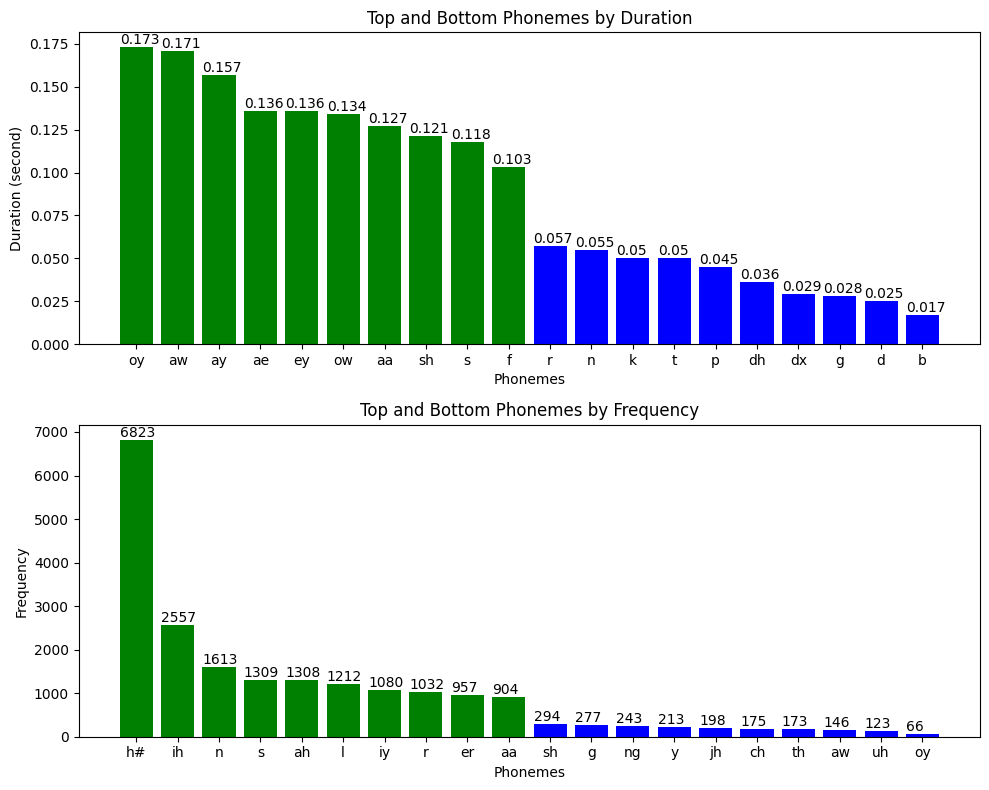

In [20]:
from collections import OrderedDict

sorted_duration_items = sorted(phoneme_duration.items(), key=lambda item: item[1])
sorted_frequency_items = sorted(phoneme_frequency.items(), key=lambda item: item[1])

top_bottom_duration = {**dict(sorted_duration_items[:10]), **dict(sorted_duration_items[-10:])}
top_bottom_frequency = {**dict(sorted_frequency_items[:10]), **dict(sorted_frequency_items[-10:])}

top_bottom_duration = OrderedDict(sorted(top_bottom_duration.items(), key=lambda item: item[1], reverse=True))
top_bottom_frequency = OrderedDict(sorted(top_bottom_frequency.items(), key=lambda item: item[1], reverse=True))

colors = ['green'] * 10 + ['blue'] * 10

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

bar1 = axs[0].bar(top_bottom_duration.keys(), top_bottom_duration.values(), color=colors)
axs[0].set_title('Top and Bottom Phonemes by Duration')
axs[0].set_xlabel('Phonemes')
axs[0].set_ylabel('Duration (second)')

for bar in bar1:
    yval = bar.get_height()
    axs[0].text(bar.get_x(), yval, f'{yval}', va='bottom')

bar2 = axs[1].bar(top_bottom_frequency.keys(), top_bottom_frequency.values(), color=colors)
axs[1].set_title('Top and Bottom Phonemes by Frequency')
axs[1].set_xlabel('Phonemes')
axs[1].set_ylabel('Frequency')

for bar in bar2:
    yval = bar.get_height()
    axs[1].text(bar.get_x(), yval, f'{yval}', va='bottom')

plt.tight_layout()

plt.savefig('phoneme_frequency_duration.png')

plt.show()

In [16]:
def read_and_convert_phonemes(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    end_time = 0
    
    phoneme_indices = []
    
    for line in lines:
        parts = line.strip().split()
        
        if len(parts) != 3:
            continue
        end_time = parts[1]
        phoneme = parts[2]

        if phoneme in pho61_to_pho39:
            pho39 = pho61_to_pho39[phoneme]
            if pho39 in pho39_to_index:
                index = pho39_to_index[pho39]-1
                phoneme_indices.append(index)
    phoneme_indices.append(39)
    
    return phoneme_indices,end_time

In [17]:
from scipy.io.wavfile import read

print(tacotron_file_list[0])

audio_length = 0

for file in tacotron_file_list:
    sr, audio = read(file['audio_file'])
    audio_length += len(audio)
    
print(audio_length/16000)

{'phonetic_file': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR4/FEEH0/SX32.PHN', 'word_file': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR4/FEEH0/SX32.WRD', 'audio_file': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR4/FEEH0/SX32.WAV.wav'}
2469.8438125


In [18]:
complete_files = []
for key,value in audio_files.items():
    if len(value) == 3:
        complete_files.append(value)
        
print(len(complete_files))

3360


In [19]:
complete_files_exSA = []
for key,value in audio_exSA_files.items():
    if len(value) == 3:
        complete_files_exSA.append(value)
        
print(len(complete_files_exSA))

2688
